## Facial keypoints detection

In this task you will create facial keypoint detector based on CNN regressor.


![title](example.png)

### Load and preprocess data

Script `get_data.py` unpacks data — images and labelled points. 6000 images are located in `images` folder and keypoint coordinates are in `gt.csv` file. Run the cell below to unpack data.

In [1]:
from get_data import unpack
unpack('facial-keypoints-data.zip')

Now you have to read `gt.csv` file and images from `images` dir. File `gt.csv` contains header and ground truth points for every image in `images` folder. It has 29 columns. First column is a filename and next 28 columns are `x` and `y` coordinates for 14 facepoints. We will make following preprocessing:
1. Scale all images to resolution $100 \times 100$ pixels.
2. Scale all coordinates to range $[-0.5; 0.5]$. To obtain that, divide all x's by width (or number of columns) of image, and divide all y's by height (or number of rows) of image and subtract 0.5 from all values.

Function `load_imgs_and_keypoint` should return a tuple of two numpy arrays: `imgs` of shape `(N, 100, 100, 3)`, where `N` is the number of images and `points` of shape `(N, 28)`.

In [3]:
### Useful routines for preparing data
from numpy import array, zeros
from os.path import join
from skimage.color import gray2rgb
from skimage.io import imread
from skimage.transform import resize
import os
import numpy as np
import pandas as pd
#from PIL import Image

def load_imgs_and_keypoints(dirname='data/images'):
    crop_size = 100
    images_list = []
    i = 0
    
    coordinates = pd.read_csv('data/gt.csv', sep=',') 
    points = array(coordinates.values[:,1:])
    
    for root, dirs, files in os.walk(dirname):
        for each_file in files:
            image_path = dirname + '/' + each_file
            each_image = imread(image_path)
            for j in range(0,int(points.shape[1]/2)):
                points[i,2*j] = points[i,2*j]/each_image.shape[0] - 0.5
                points[i,2*j+1] = points[i,2*j+1]/each_image.shape[1] - 0.5
            i = i+1           
            each_image = resize(each_image, (crop_size,crop_size))
            if len(each_image.shape) != 3:
                each_image = gray2rgb(each_image)
            images_list.append(each_image) 
            
    images = zeros((len(images_list),crop_size,crop_size,3))
    images = array(images_list)
    
    return images, points


imgs, points = load_imgs_and_keypoints()


C:\Users\brook\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


C:\Users\brook\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
C:\Users\brook\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


array([-0.3053435114503817, -0.3053435114503817, -0.01526717557251911,
       -0.27099236641221375, 0.14503816793893132, -0.25190839694656486,
       0.2748091603053435, -0.3015267175572519, -0.24045801526717558,
       -0.20610687022900764, -0.17557251908396948, -0.2137404580152672,
       -0.08015267175572521, -0.18702290076335876, 0.11068702290076338,
       -0.16793893129770993, 0.15267175572519087, -0.1984732824427481,
       0.23664122137404575, -0.17938931297709926, 0.09541984732824427,
       0.04961832061068705, -0.1488549618320611, 0.16412213740458015,
       0.03435114503816794, 0.1870229007633588, 0.14122137404580148,
       0.18320610687022898], dtype=object)

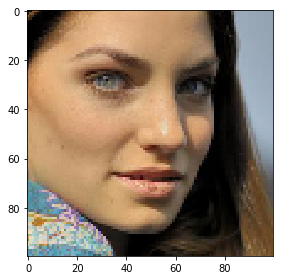

In [4]:
# Example of output
%matplotlib inline
from skimage.io import imshow
imshow(imgs[0])
points[0]

### Visualize data

Let's prepare a function to visualize points on image. Such function obtains two arguments: an image and a vector of points' coordinates and draws points on image (just like first image in this notebook).

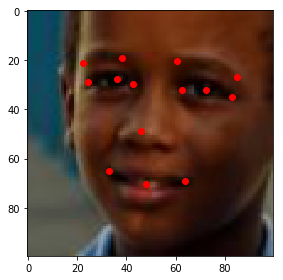

In [5]:
import matplotlib.pyplot as plt
#from matplotlib.patches import Circle

def visualize_points(img, points):
    # img is a rgb array
    # points is an array of xy coordinates, in the following format:
    #   x0, y0, x1, y1, x2, y2 .... etc.
    
    fig, ax = plt.subplots(figsize=(4,4))
    plt.imshow(img)
    x = []
    y = []
    for i in range(0,int(points.shape[0]/2)):
        # Convert xy coordinates from -0.5:0.5 to 0:100
        x.append((points[i*2]+.5)*100)
        y.append((points[i*2+1]+.5)*100)
    x = array(x)
    y = array(y)
    plt.plot(x,y,'ro')
    plt.tight_layout()
    pass
    
visualize_points(imgs[1], points[1])

### Train/val split

Run the following code to obtain train/validation split for training neural network.

In [6]:
from sklearn.model_selection import train_test_split
imgs_train, imgs_val, points_train, points_val = train_test_split(imgs, points, test_size=0.1)

### Simple data augmentation

For better training we will use simple data augmentation — flipping an image and points. Implement function flip_img which flips an image and its' points. Make sure that points are flipped correctly! For instance, points on right eye now should be points on left eye (i.e. you have to mirror coordinates and swap corresponding points on the left and right sides of the face). VIsualize an example of original and flipped image.

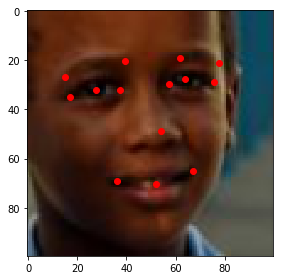

In [92]:
 def reorder_points(points, p1, p2):
    # Points are stored as an array: x0, y0, x1, y1, x2, y2, etc.
    index1 = p1*2
    index2 = p2*2
    reordered_points = np.copy(points)

    reordered_points[index1] = points[index2]
    reordered_points[index1+1] = points[index2+1]
    reordered_points[index2] = points[index1]
    reordered_points[index2+1] = points[index1+1] 
    
    return reordered_points

def flip_img(img, points):
    # Flip points right to left
    f_points = []
    for i in range(0,int(points.shape[0]/2)):      
        f_points.append(points[i*2]*(-1))
        f_points.append(points[i*2+1])
    f_points = array(f_points)
    
    # Reorder points in array
    f_points = reorder_points(f_points, 0, 3)
    f_points = reorder_points(f_points, 1, 2)
    f_points = reorder_points(f_points, 4, 9)
    f_points = reorder_points(f_points, 5, 8)
    f_points = reorder_points(f_points, 6, 7)
    f_points = reorder_points(f_points, 11, 13)
   
    # Flip image right to left
    f_img = np.flip(img,axis=1)
    return f_img, f_points

f_img, f_points = flip_img(imgs[1], points[1])
visualize_points(f_img, f_points)

Time to augment our training sample. Apply flip to every image in training sample. As a result you should obtain two arrays: `aug_imgs_train` and `aug_points_train` which contain original images and points along with flipped ones.

In [93]:
# Flip all images and keypoints
# Combine flipped images/keypoints and originals
aug_imgs_train = []
aug_points_train = []
for i in range(0,imgs.shape[0]):
    f_img, f_points = flip_img(imgs[i], points[i])
    aug_imgs_train.append(imgs[i])
    aug_imgs_train.append(f_img)
    aug_points_train.append(points[i])
    aug_points_train.append(f_points)
    
aug_imgs_train = array(aug_imgs_train)
aug_points_train = array(aug_points_train)

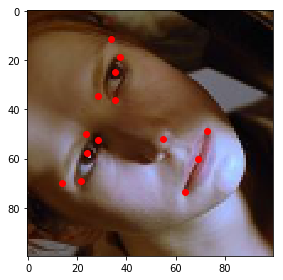

In [94]:
visualize_points(aug_imgs_train[4], aug_points_train[4])

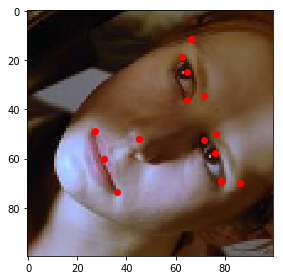

In [95]:
visualize_points(aug_imgs_train[5], aug_points_train[5])

### Network architecture and training

Now let's define neural network regressor. It will have 28 outputs, 2 numbers per point. The precise architecture is up to you. We recommend to add 2-3 (`Conv2D` + `MaxPooling2D`) pairs, then `Flatten` and 2-3 `Dense` layers. Don't forget about ReLU activations. We also recommend to add `Dropout` to every `Dense` layer (with p from 0.2 to 0.5) to prevent overfitting.


In [96]:
from keras.models import Sequential
from keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout, Reshape, LeakyReLU
)
image_size = 100
num_classes = 28
model = Sequential()

# Add 2-3 Conv2D + MaxPooling2D pairs
model.add(Conv2D(32, kernel_size=(3,3), input_shape=(aug_imgs_train[0].shape), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same',))
model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

# Flatten
model.add(Flatten())

# Add 2-3 Dense layers with Dropout
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes))
    
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 100, 100, 32)      896       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 25, 25, 128)       73856     
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 13, 13, 128)       0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 21632)             0         
__________

Time to train! Since we are training a regressor, make sure that you use mean squared error (mse) as loss. Feel free to experiment with optimization method (SGD, Adam, etc.) and its' parameters.

In [97]:
# ModelCheckpoint can be used for saving model during training.
# Saved models are useful for finetuning your model 
# See keras documentation for more info
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam
from tensorflow.python.keras.applications.resnet50 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

batch_size = 64
epochs = 10

# Compile Model
model.compile(optimizer=Adam(), loss='mse', metrics=['accuracy'])

# Fit Model
ModelCheckpoint('summary.txt')
trained_model = model.fit(aug_imgs_train, aug_points_train, batch_size=batch_size, epochs=epochs, verbose=1, shuffle=True, validation_data=(imgs_val,points_val))


Train on 12000 samples, validate on 600 samples
Epoch 1/10
12000/12000 [==============================] - 250s 21ms/step - loss: 0.0083 - acc: 0.6450 - val_loss: 0.0025 - val_acc: 0.8217
Epoch 2/10
12000/12000 [==============================] - 247s 21ms/step - loss: 0.0029 - acc: 0.7649 - val_loss: 0.0016 - val_acc: 0.8483
Epoch 3/10
12000/12000 [==============================] - 245s 20ms/step - loss: 0.0023 - acc: 0.8207 - val_loss: 0.0015 - val_acc: 0.8483
Epoch 4/10
12000/12000 [==============================] - 245s 20ms/step - loss: 0.0020 - acc: 0.8400 - val_loss: 0.0013 - val_acc: 0.8567
Epoch 5/10
12000/12000 [==============================] - 246s 20ms/step - loss: 0.0017 - acc: 0.8513 - val_loss: 0.0012 - val_acc: 0.8500
Epoch 6/10
12000/12000 [==============================] - 246s 21ms/step - loss: 0.0016 - acc: 0.8546 - val_loss: 0.0010 - val_acc: 0.8550
Epoch 7/10
12000/12000 [==============================] - 246s 20ms/step - loss: 0.0015 - acc: 0.8619 - val_loss: 9.33

### Visualize results

Now visualize neural network results on several images from validation sample. Make sure that your network outputs different points for images (i.e. it doesn't output some constant).

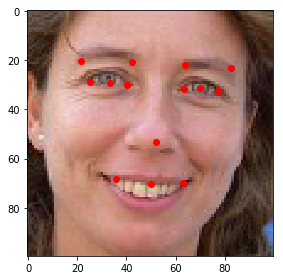

In [98]:
prediction = model.predict(imgs_val)
visualize_points(imgs_val[5], prediction[5])


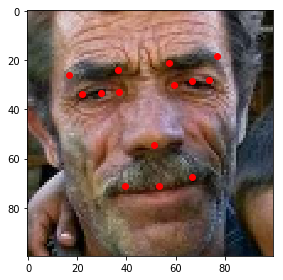

In [99]:
visualize_points(imgs_val[6], prediction[6])

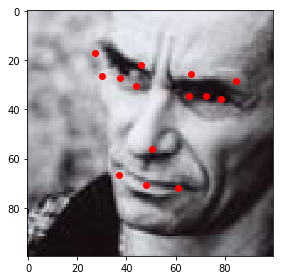

In [100]:
visualize_points(imgs_val[7], prediction[7])

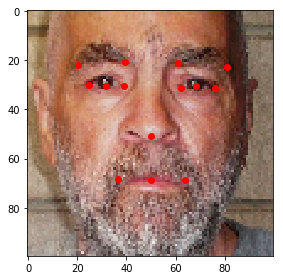

In [101]:
visualize_points(imgs_val[8], prediction[8])